1.Import Libraries

In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler

# Disable chained assignment warning
pd.set_option('mode.chained_assignment', None)

# Disable future downcasting warning
pd.set_option('future.no_silent_downcasting', True)



2.Load RAW Dataset

In [36]:
import os

# Check if the file exists
print(os.path.exists('data/raw/retail_store_sales.csv'))


True


In [4]:
import pandas as pd

raw_data_path = r'data/raw/retail_store_sales.csv' 
df = pd.read_csv(raw_data_path)
print("First 5 rows:")
display(df.head())


First 5 rows:


,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied
0,TXN_6867343,CUST_09,Patisserie,Item_10_PAT,18.5,10.0,185.0,Digital Wallet,Online,2024-04-08,True
1,TXN_3731986,CUST_22,Milk Products,Item_17_MILK,29.0,9.0,261.0,Digital Wallet,Online,2023-07-23,True
2,TXN_9303719,CUST_02,Butchers,Item_12_BUT,21.5,2.0,43.0,Credit Card,Online,2022-10-05,False
3,TXN_9458126,CUST_06,Beverages,Item_16_BEV,27.5,9.0,247.5,Credit Card,Online,2022-05-07,NaN
4,TXN_4575373,CUST_05,Food,Item_6_FOOD,12.5,7.0,87.5,Digital Wallet,Online,2022-10-02,False


3.Examine Dataset

In [37]:
print("Dataset shape:", df.shape)
display(df.info())
display(df.describe())

print("Missing values per column:")
print(df.isnull().sum())

print("Number of duplicate rows:", df.duplicated().sum())

Dataset shape: (11306, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 11306 entries, 0 to 12574
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    11306 non-null  object 
 1   Customer ID       11306 non-null  object 
 2   Category          11306 non-null  object 
 3   Item              11306 non-null  object 
 4   Price Per Unit    11306 non-null  float64
 5   Quantity          11306 non-null  float64
 6   Total Spent       11306 non-null  float64
 7   Payment Method    11306 non-null  object 
 8   Location          11306 non-null  object 
 9   Discount Applied  11306 non-null  object 
 10  Year              11306 non-null  int64  
 11  Month             11306 non-null  int64  
 12  Day               11306 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 1.2+ MB


None

,Price Per Unit,Quantity,Total Spent,Year,Month,Day
count,11306.000000,11306.000000,11306.000000,11306.000000,11306.000000,11306.000000
mean,23.269459,5.512913,128.253892,2023.042721,6.370157,15.609411
std,10.690356,2.844839,92.812029,0.855110,3.498428,8.805476
min,5.000000,1.000000,5.000000,2022.000000,1.000000,1.000000
25%,14.000000,3.000000,51.000000,2022.000000,3.000000,8.000000
50%,23.000000,6.000000,108.500000,2023.000000,6.000000,15.000000
75%,32.000000,8.000000,190.000000,2024.000000,9.000000,23.000000
max,41.000000,10.000000,395.000000,2025.000000,12.000000,31.000000


Missing values per column:
Transaction ID      0
Customer ID         0
Category            0
Item                0
Price Per Unit      0
Quantity            0
Total Spent         0
Payment Method      0
Location            0
Discount Applied    0
Year                0
Month               0
Day                 0
dtype: int64
Number of duplicate rows: 0


4.Handle Missing Values and Save Cleaned Dataset

In [38]:
# Drop rows with missing 'Item'
df = df.dropna(subset=['Item'])

# Fill numeric missing values with median
num_cols = ['Price Per Unit', 'Quantity', 'Total Spent']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical missing values with mode
df['Discount Applied'] = df['Discount Applied'].fillna(df['Discount Applied'].mode()[0])

# Remove duplicate rows
df = df.drop_duplicates()

# Ensure the processed directory exists
processed_dir = 'data/processed/'
os.makedirs(processed_dir, exist_ok=True)

# Save the cleaned dataset
output_path = os.path.join(processed_dir, 'cleaned1_clustering.csv')
df.to_csv(output_path, index=False)

# Confirmation prints
print("Missing values after cleaning:\n", df.isnull().sum())
print("Number of duplicate rows after cleaning:", df.duplicated().sum())
print(f"Cleaned dataset successfully saved at: {output_path}")
print("Check existence:", os.path.exists(output_path))

# ADDITIONAL FIXES 

# Normalize column names
df.columns = df.columns.str.strip()

# Try several common date column name variants, create Year/Month/Day if found
date_col_candidates = ['Transaction Date', 'Transaction_Date', 'TransactionDate', 'Date']
found_date_col = None
for c in date_col_candidates:
    if c in df.columns:
        found_date_col = c
        df[c] = pd.to_datetime(df[c], errors='coerce')
        df['Year'] = df[c].dt.year
        df['Month'] = df[c].dt.month
        df['Day'] = df[c].dt.day
        # drop the original date column
        df = df.drop(columns=[c])
        break

# If no date column found but Year/Month/Day already exist, ensure they are integers
if found_date_col is None:
    if all(col in df.columns for col in ['Year', 'Month', 'Day']):
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(0).astype(int)
        df['Month'] = pd.to_numeric(df['Month'], errors='coerce').fillna(0).astype(int)
        df['Day'] = pd.to_numeric(df['Day'], errors='coerce').fillna(0).astype(int)
    else:
        print("No transaction date column found; Year/Month/Day were not created.")

Missing values after cleaning:
 Transaction ID      0
Customer ID         0
Category            0
Item                0
Price Per Unit      0
Quantity            0
Total Spent         0
Payment Method      0
Location            0
Discount Applied    0
Year                0
Month               0
Day                 0
dtype: int64
Number of duplicate rows after cleaning: 0
Cleaned dataset successfully saved at: data/processed/cleaned1_clustering.csv
Check existence: True


5.Outlier Detection & Removal using IQR

In [39]:

def remove_outliers_iqr(data, col):
    """
    Remove outliers from a numeric column using the IQR method.
    """
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    filtered_data = data[(data[col] >= lower) & (data[col] <= upper)]
    removed_count = data.shape[0] - filtered_data.shape[0]
    print(f"{removed_count} outliers removed from '{col}'")
    return filtered_data

# Apply outlier removal for each numeric column
num_cols = ['Price Per Unit', 'Quantity', 'Total Spent']
for col in num_cols:
    df = remove_outliers_iqr(df, col)

# Print final shape after outlier removal
print("Dataset shape after outlier removal:", df.shape)

# Save the dataset after outlier removal (optional)
output_path_outliers = os.path.join('data/processed', 'cleaned2_no_outliers.csv')
df.to_csv(output_path_outliers, index=False)
print(f"Dataset after outlier removal saved at: {output_path_outliers}")
print("Check existence:", os.path.exists(output_path_outliers))


0 outliers removed from 'Price Per Unit'
0 outliers removed from 'Quantity'
0 outliers removed from 'Total Spent'
Dataset shape after outlier removal: (11306, 13)
Dataset after outlier removal saved at: data/processed\cleaned2_no_outliers.csv
Check existence: True


6.Encoding Categorical Columns

In [40]:

categorical_cols = ['Category', 'Item', 'Payment Method', 'Location', 'Discount Applied']

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Print confirmation
print("Original number of columns:", df.shape[1])
print("Number of columns after encoding:", df_encoded.shape[1])
print("Sample of encoded columns:")
display(df_encoded.head())

# save encoded dataset
encoded_output_path = 'data/processed/encoded_clustering.csv'
df_encoded.to_csv(encoded_output_path, index=False)
print(f"Encoded dataset saved at: {encoded_output_path}")
print("Check existence:", os.path.exists(encoded_output_path))


Original number of columns: 13
Number of columns after encoding: 218
Sample of encoded columns:


,Transaction ID,Customer ID,Price Per Unit,Quantity,Total Spent,Year,Month,Day,Category_Butchers,Category_Computers and electric accessories,...,Item_Item_9_CEA,Item_Item_9_EHE,Item_Item_9_FOOD,Item_Item_9_FUR,Item_Item_9_MILK,Item_Item_9_PAT,Payment Method_Credit Card,Payment Method_Digital Wallet,Location_Online,Discount Applied_True
0,TXN_6867343,CUST_09,18.5,10.0,185.0,2024,4,8,False,False,...,False,False,False,False,False,False,False,True,True,True
1,TXN_3731986,CUST_22,29.0,9.0,261.0,2023,7,23,False,False,...,False,False,False,False,False,False,False,True,True,True
2,TXN_9303719,CUST_02,21.5,2.0,43.0,2022,10,5,True,False,...,False,False,False,False,False,False,True,False,True,False
3,TXN_9458126,CUST_06,27.5,9.0,247.5,2022,5,7,False,False,...,False,False,False,False,False,False,True,False,True,True
4,TXN_4575373,CUST_05,12.5,7.0,87.5,2022,10,2,False,False,...,False,False,False,False,False,False,False,True,True,False


Encoded dataset saved at: data/processed/encoded_clustering.csv
Check existence: True


7.Feature Scaling

In [41]:

from sklearn.preprocessing import StandardScaler

# Columns to scale (exclude non-numeric original columns)
cols_to_scale = df_encoded.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()

df_scaled = df_encoded.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_encoded[cols_to_scale])

# Print confirmation
print("First 5 rows after scaling numeric columns:")
display(df_scaled.head())

print("Check min and max of scaled columns:")
print(df_scaled[cols_to_scale].describe().loc[['min','max']])

# Save final preprocessed dataset
final_output_path = 'data/processed/final_preprocessed_clustering.csv'
df_scaled.to_csv(final_output_path, index=False)

print(f"Final preprocessed dataset saved at: {final_output_path}")
print("Check existence:", os.path.exists(final_output_path))



First 5 rows after scaling numeric columns:


,Transaction ID,Customer ID,Price Per Unit,Quantity,Total Spent,Year,Month,Day,Category_Butchers,Category_Computers and electric accessories,...,Item_Item_9_CEA,Item_Item_9_EHE,Item_Item_9_FOOD,Item_Item_9_FUR,Item_Item_9_MILK,Item_Item_9_PAT,Payment Method_Credit Card,Payment Method_Digital Wallet,Location_Online,Discount Applied_True
0,TXN_6867343,CUST_09,-0.446166,1.577342,0.611436,1.119530,-0.677522,-0.864206,False,False,...,False,False,False,False,False,False,False,True,True,True
1,TXN_3731986,CUST_22,0.536071,1.225813,1.430332,-0.049961,0.180044,0.839354,False,False,...,False,False,False,False,False,False,False,True,True,True
2,TXN_9303719,CUST_02,-0.165526,-1.234892,-0.918606,-1.219453,1.037610,-1.204918,True,False,...,False,False,False,False,False,False,True,False,True,False
3,TXN_9458126,CUST_06,0.395752,1.225813,1.284870,-1.219453,-0.391667,-0.977777,False,False,...,False,False,False,False,False,False,True,False,True,True
4,TXN_4575373,CUST_05,-1.007444,0.522754,-0.439121,-1.219453,1.037610,-1.545631,False,False,...,False,False,False,False,False,False,False,True,True,False


Check min and max of scaled columns:
     Price Per Unit  Quantity  Total Spent      Year     Month       Day
min       -1.709042 -1.586421    -1.328054 -1.219453 -1.535088 -1.659201
max        1.658628  1.577342     2.874174  2.289022  1.609320  1.747920
Final preprocessed dataset saved at: data/processed/final_preprocessed_clustering.csv
Check existence: True


8.Visualizations

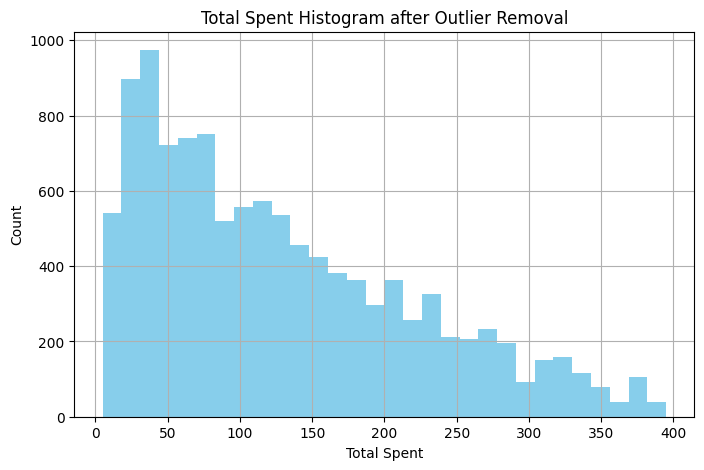

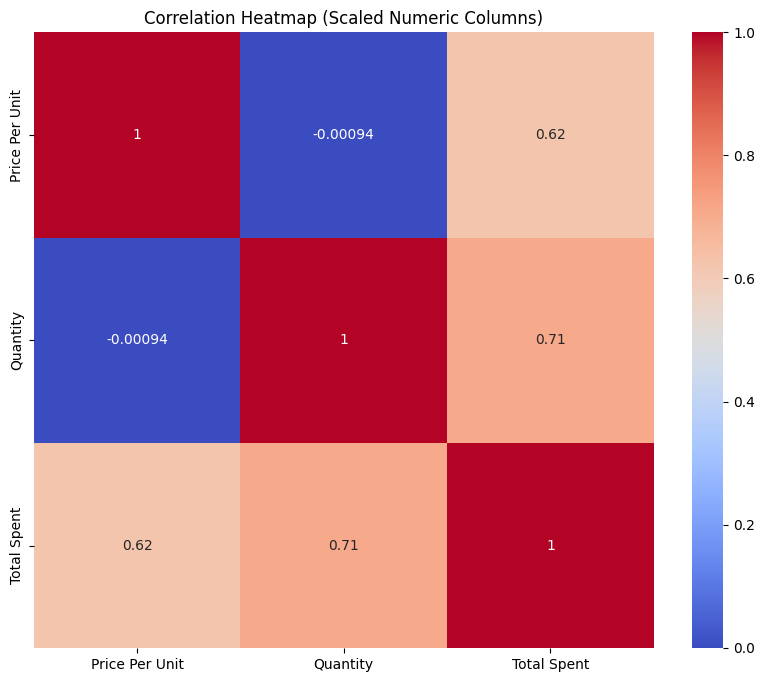

In [42]:

import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for Total Spent after outlier removal
plt.figure(figsize=(8,5))
df['Total Spent'].hist(bins=30, color='skyblue')
plt.title('Total Spent Histogram after Outlier Removal')
plt.xlabel('Total Spent')
plt.ylabel('Count')
plt.show()

# Correlation Heatmap for scaled numeric columns
plt.figure(figsize=(10,8))
sns.heatmap(df_scaled[['Price Per Unit','Quantity','Total Spent']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Scaled Numeric Columns)')
plt.show()
